# Solve cartpole with REINFORCE

> By Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk))

**2019 update:** Changes have been made to the display of environments due to the previous `viewer` being incompatible with newer versions of Gym.

**2022 update:** Rendering was disabled, and the notebook now uses the `colabgymrender` package to render a video.

**2023 update:** Changed to packages `gymnasium` and `renderlab`, and to `CartPole-v1`.

In this part, we will create an agent that can learn to solve the [cartpole problem](https://gymnasium.farama.org/environments/classic_control/cart_pole/) from OpenAI Gym by applying a simple policy gradient method called REINFORCE.
In the cartpole problem, we need to balance a pole on a cart that moves along a track by applying left and right forces to the cart.

We will implement a probabilistic policy, that given a state of the environment, $s$, outputs a probability distribution over available actions, $a$:

$$
p_\theta(a|s)
$$

The policy is a neural network with parameters $\theta$ that can be trained with gradient descent.
When the set of available actions is discrete, we can use a network with softmax output do describe the distribution.
The core idea of training the policy network is quite simple: *we want to maximize the expected total reward by increasing the probability of good actions and decreasing the probability of bad actions*.

To achieve this, we apply the gradient of the expected discounted total reward (return):

$$
\begin{align}
\nabla_\theta \mathbb{E}[R|\theta] &= \nabla_\theta \int p_\theta(a|s) R({a}) \, da \\
&= \int \nabla_\theta p_\theta(a|s) R(a)  \, da \\
&= \int p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) R(a) \, da \\
&= \mathbb{E}[\nabla_\theta \log p_\theta(a|s) R(a)]
\end{align}
$$

by definition of expectation and using the identity

$$
\nabla_\theta p_\theta(a|s) = p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) \ .
$$

The expectation cannot be evaluated analytically, but we have an environment simulator that when supplied with our current policy $p_\theta(a|s)$ can return a sequence of *actions*, *states* and *rewards*. This allows us to replace the integral with a Monte Carlo average:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) R_t \ ,
$$

which is our final gradient estimator, also known as REINFORCE. In the Monte Carlo estimator we run the environment simulator for a predefined number of steps with actions chosen stochastically according to the current stochastic action network $p_\theta(a|s)$.

*Note: For simple reinforcement learning problems (like the one we will address in this exercise) there are simpler methods that work just fine. However, the Policy Gradient method (with some extensions) has been shown to also work well for complex problems with high dimensional inputs and many parameters, where simple methods become inadequate.*

## Policy gradient

In [1]:
!pip install gymnasium
!pip install renderlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 10.1 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import renderlab as rl

  if event.key is 'enter':



First we create the environment:

In [3]:
env = gym.make('CartPole-v1') # Create environment

A state in this environment is four numbers describing the position and speed of the cart along with the angle and angular speed of the pole.

There are two available actions: push the cart *left* or *right* encoded as 0 and 1.

In [4]:
s, _ = env.reset()
a = env.action_space.sample()
print('sample state:', s)
print('sample action:', a )

sample state: [ 0.02991729 -0.01531324 -0.01589537  0.02712208]
sample action: 0


Let us see how the environment looks when we just take random actions. Note that the episode ends when the pole either 1) is more than 15 degrees from vertical, 2) more outside of the frame or 3) the pole is successfully balanced for some fixed duration.

In [5]:
env = gym.make("CartPole-v1", render_mode = "rgb_array") # Create environment
env = rl.RenderFrame(env, "./output") # To display environment in the notebook
env.reset() # Reset environment

# Run environment
while True:
    action = env.action_space.sample() # Get a random action
    _, _, done, _, _ = env.step(action) # Take a step
    # observation, reward, terminated, truncated, info
    if done: break # Break if environment is done

env.close() # Close environment
env.play()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./output/1729942130.8076704.mp4, 720000 bytes wanted but 0 bytes read,at frame 14/15, at time 0.47/0.47 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                   

Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Taking random actions does not do a very good job at balancing the pole. Let us now apply the Policy Gradient method described above to solve this task!

Let's first define our network and helper functions.

In [6]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.hidden = nn.Linear(n_inputs, n_hidden)
        self.out = nn.Linear(n_hidden, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(x)
        x = self.out(x)
        return F.softmax(x, dim=1)

    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

In [7]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

To start with, our policy will be a rather simple neural network with one hidden layer. We can retrieve the shape of the state space (input) and action space (output) from the environment.

In [8]:
n_inputs = env.observation_space.shape[0]
n_hidden = 20
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)

state shape: 4
action shape: 2


In [9]:
# training settings

num_episodes = 800
rollout_limit = 500 # max rollout length
# discount_factor = 1.0 # reward discount factor (gamma), 1.0 = no discount
discount_factor = 0.9
learning_rate = 0.001 # you know this by now
val_freq = 100 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s, _ = env.reset()
        for j in range(rollout_limit):
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                a = torch.multinomial(a_prob, num_samples=1).squeeze().numpy()
            s1, r, done, _, _ = env.step(a)
            rollout.append((s, a, r))
            s = s1
            if done: break
        # prepare batch
        states = np.vstack([x[0] for x in rollout])
        actions = np.array([x[1] for x in rollout], dtype=np.int64).reshape(-1, 1)
        rewards = np.array([x[2] for x in rollout], dtype=np.float32)
        returns = compute_returns(rewards, discount_factor)
        # policy gradient update
        policy.optimizer.zero_grad()
        # here we take only the probabilites that led to the particular action
        a_probs = policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s, _ = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                        a = a_prob.argmax().item()
                    s, r, done, _, _ = env.step(a)
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')

start training
 100. mean training reward:  26.68, mean validation reward:  24.90, mean loss:  9.4733
 200. mean training reward:  30.15, mean validation reward:  57.00, mean loss: 10.5869
 300. mean training reward:  33.91, mean validation reward:  89.50, mean loss: 11.6625
 400. mean training reward:  40.23, mean validation reward: 179.30, mean loss: 13.6265
 500. mean training reward:  48.96, mean validation reward: 142.90, mean loss: 16.1596
 600. mean training reward:  62.92, mean validation reward: 156.40, mean loss: 20.1951
 700. mean training reward:  83.04, mean validation reward: 239.30, mean loss: 26.1817
 800. mean training reward: 124.67, mean validation reward: 309.80, mean loss: 38.7140
done


In [24]:
import torch
import numpy as np
from torch.amp import autocast, GradScaler

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move policy network to GPU
policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate).to(device)

# Initialize gradient scaler for mixed precision training
scaler = GradScaler()

# training settings
# num_episodes = 800
# rollout_limit = 500
# discount_factor = 1.0
# learning_rate = 0.001
# val_freq = 100
num_episodes = 800
rollout_limit = 500
discount_factor = 0.99
learning_rate = 0.001
val_freq = 100

# Batch processing helper function
def process_batch(states, actions, rewards):
    states = torch.from_numpy(states).float().to(device)
    actions = torch.from_numpy(actions).to(device)
    returns = compute_returns(rewards, discount_factor)
    returns = torch.from_numpy(returns).float().to(device)
    return states, actions, returns

try:
    training_rewards, losses = [], []
    print('start training')

    for i in range(num_episodes):
        rollout = []
        s, _ = env.reset()

        # Generate rollout
        for j in range(rollout_limit):
            with torch.no_grad():
                s_tensor = torch.from_numpy(np.atleast_2d(s)).float().to(device)
                a_prob = policy(s_tensor)
                a = torch.multinomial(a_prob, num_samples=1).squeeze().cpu().numpy()

            s1, r, done, _, _ = env.step(a)
            rollout.append((s, a, r))
            s = s1
            if done: break

        # Prepare batch
        states = np.vstack([x[0] for x in rollout])
        actions = np.array([x[1] for x in rollout], dtype=np.int64).reshape(-1, 1)
        rewards = np.array([x[2] for x in rollout], dtype=np.float32)

        # Move data to GPU and process in mixed precision
        states, actions, returns = process_batch(states, actions, rewards)

        # Policy gradient update with mixed precision
        policy.optimizer.zero_grad()

        if torch.cuda.is_available():
            with autocast('cuda'):
                a_probs = policy(states).gather(1, actions).view(-1)
                loss = policy.loss(a_probs, returns)
        else:
            with autocast('cpu'):
                a_probs = policy(states).gather(1, actions).view(-1)
                loss = policy.loss(a_probs, returns)

        # Scale loss and backpropagate
        scaler.scale(loss).backward()
        scaler.step(policy.optimizer)
        scaler.update()

        # Bookkeeping (using CPU for numpy operations)
        training_rewards.append(sum(rewards))
        losses.append(loss.item())

        # Validation
        if (i+1) % val_freq == 0:
            validation_rewards = []
            for _ in range(10):
                s, _ = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        s_tensor = torch.from_numpy(np.atleast_2d(s)).float().to(device)
                        a_prob = policy(s_tensor)
                        a = a_prob.argmax().item()
                    s, r, done, _, _ = env.step(a)
                    reward += r
                    if done: break
                validation_rewards.append(reward)

            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(
                i+1,
                np.mean(training_rewards[-val_freq:]),
                np.mean(validation_rewards),
                np.mean(losses[-val_freq:])
            ))

    print('done')

except KeyboardInterrupt:
    print('interrupt')
finally:
    # Clean up
    torch.cuda.empty_cache()

Using device: cuda
start training
 100. mean training reward:  23.71, mean validation reward:   9.70, mean loss:  8.5169
 200. mean training reward:  26.65, mean validation reward:  78.10, mean loss:  9.4646
 300. mean training reward:  30.36, mean validation reward:  89.90, mean loss: 10.6314
 400. mean training reward:  28.99, mean validation reward:  50.70, mean loss: 10.0253
 500. mean training reward:  31.22, mean validation reward:  44.80, mean loss: 10.7051
 600. mean training reward:  36.19, mean validation reward:  46.90, mean loss: 12.1265
 700. mean training reward:  41.48, mean validation reward: 208.70, mean loss: 13.6177
 800. mean training reward:  42.81, mean validation reward: 214.80, mean loss: 13.8233
done


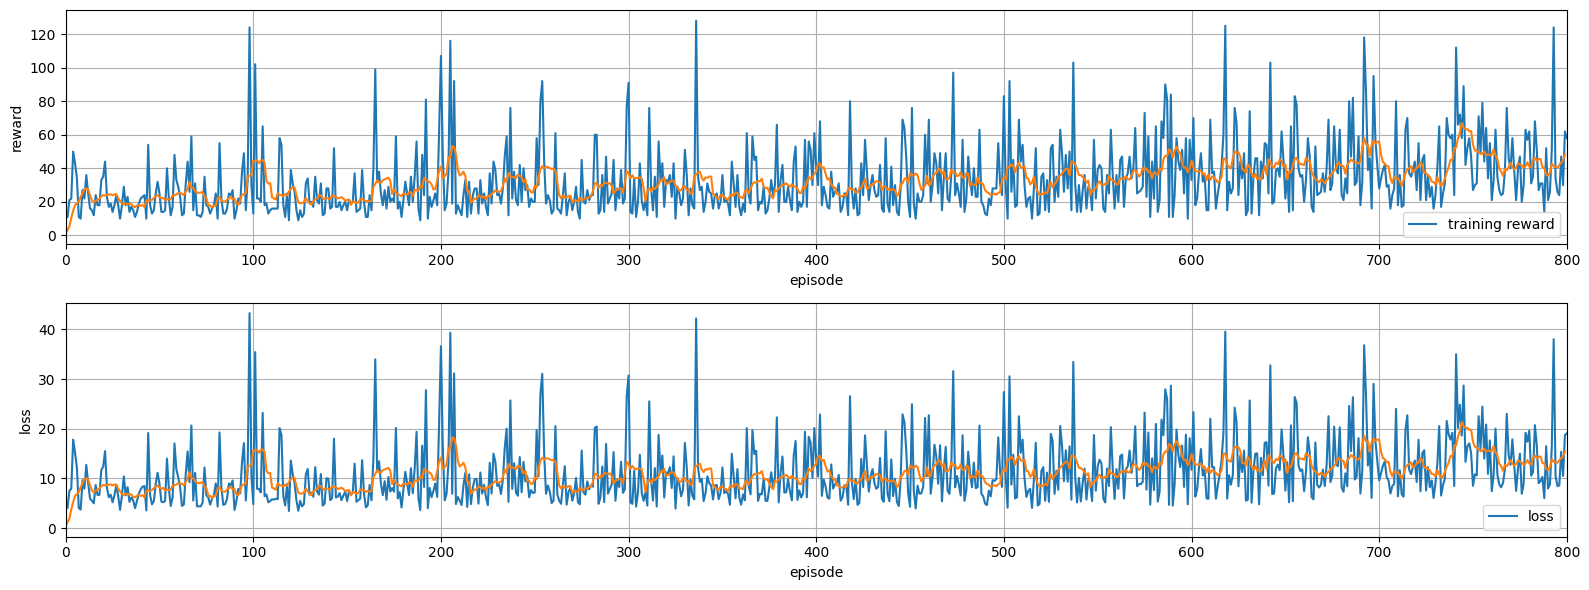

In [25]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

Now let's review the solution!

In [22]:
env = rl.RenderFrame(env, "./gym-results") # Create wrapper to display environment
s,_ = env.reset()

for _ in range(500):
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _, _ = env.step(a)
    if done: break

env.play()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [26]:
# Wrap environment for rendering
env = rl.RenderFrame(env, "./gym-results")

# Get initial state
s, _ = env.reset()

# Move policy to evaluation mode
policy.eval()

with torch.no_grad():  # Disable gradient computation for inference
    for _ in range(500):
        # Convert state to tensor and move to GPU
        state_tensor = torch.from_numpy(np.atleast_2d(s)).float().to(device)

        # Get action using policy (keeping computation on GPU until we need the actual action)
        action_probs = policy(state_tensor)
        action = action_probs.argmax(dim=-1).cpu().item()

        # Take step in environment
        s, r, done, _, _ = env.step(action)

        if done:
            break

# Play the recorded frames
env.play()

# Clean up
torch.cuda.empty_cache()  # Free up GPU memory
policy.train()  # Return policy to training mode if you plan to train more

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



t:  97%|█████████▋| 76/78 [00:00<00:00, 299.38it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./gym-results/1729946445.3048077.mp4, 720000 bytes wanted but 0 bytes read,at frame 77/78, at time 2.57/2.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


PolicyNet(
  (hidden): Linear(in_features=4, out_features=20, bias=True)
  (out): Linear(in_features=20, out_features=2, bias=True)
)

In [32]:
returns = [0, 1, 1, 1, 0, 1, 1, 0, 0, 0]
discounted_returns = []
gamma = 0.9

for t in range(len(returns)):
    discounted_return = 0
    for k in range(t, len(returns)):
        discounted_return += returns[k] * (gamma ** (k - t))
    discounted_returns.append(discounted_return)

print(discounted_returns)


[3.560931, 3.95659, 3.2851, 2.539, 1.71, 1.9, 1.0, 0.0, 0.0, 0.0]


## Reducing variance

By default, this gradient estimator has high variance and therefore variance reduction becomes important to learn more complex tasks.
We can reduce variance by subtracting a baseline from the returns, which is unbiased in expectation:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) (R_t-b_t) \ ,
$$

where the baseline, $b_t$, is estimated by the return a timestep $t$ averaged over $V$ rollouts.

$$
b_t = \frac{1}{V} \sum_{v=1}^V R_t^{(v)} \ .
$$

## Exercises

Now it is your turn! Make sure you read and understand the code, then play around with it and try to make it learn better and faster.

Experiment with the:

* number of episodes
* discount factor
* learning rate
* network layers


### Exercise 1

*Describe any changes you made to the code and why you think they improve the agent. Are you able to get solutions consistently?*

**Answer:**

*Answer here...*

### Exercise 2

*Consider the following sequence of rewards produced by an agent interacting with an environment for 10 timesteps:*

[0, 1, 1, 1, 0, 1, 1, 0, 0, 0]

* *What is the total reward?*
* *What is the total future reward in each timestep?*
* *What is the discounted future reward in each timestep if $\gamma = 0.9$?*

*Hint: See introdution notebook.*

**Answer:**

Total reward: 5

Total future reward in each timestep: [5, 5, 4, 3, 2, 2, 1, 0, 0, 0]

Discounted future reward in each timestep: [3.560931, 3.95659, 3.2851, 2.539, 1.71, 1.9, 1.0, 0.0, 0.0, 0.0]

### Exercise 3

*In the training output, you will sometimes observe the validation reward starts out lower than the training reward but as training progresses they cross over and the validation reward becomes higher than the training reward. How can you explain this behavior?*

*Hint: Do we use the policy network in the same way during training and validation?*

**Answer:**

During training, actions are sampled from the policy's output probability distribution using stochastic sampling (torch.multinomial). As a result, even when the policy is not yet well-optimized, the training reward may be higher due to occasional exploration of rewarding actions.

During validation, the agent follows a deterministic policy by choosing the action with the highest probability (a_prob.argmax()). Initially, when the policy is not well-optimized, this approach may yield lower rewards compared to training because the agent is not exploring other actions that might lead to higher rewards.

### Exercise 4

*How does the policy gradient method we have used address the exploration-exploitation dilemma?*

*Hint: See the introduction notebook about exploration-exploitation.*

**Answer:**

The epsilon-greedy strategy addresses the exploration-exploitation dilemma by introducing a probability-based approach. It primarily selects the action with the highest estimated reward but also has a small probability, epsilon (ε), of choosing a random action to explore less obvious possibilities. This allows the agent to balance between exploiting known rewarding actions and discovering potentially better options








### Exercise 5 [optional]

Extend the code above to reduce variance of the gradient estimator by computing and subtracting the baseline estimate.

*Hint: You need to sample a batch of rollouts (now we sample just one) for each update in order to compute the baseline, $b_t$.*